<a href="https://colab.research.google.com/github/felicityxchang/cs152/blob/main/CS152_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Install dependencies
!pip install torch transformers scikit-learn pandas tqdm

# Cell 2: Check GPU
import torch
print(f"Using GPU: {torch.cuda.is_available()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Setup cell - Run this first in Google Colab

# 1. Install kaggle API
!pip install kaggle

# 2. Upload your kaggle.json file when prompted
from google.colab import files
import os

print("Please upload your kaggle.json file")
print("Get it from: https://www.kaggle.com/settings -> Account -> Create New API Token")
uploaded = files.upload()

# 3. Setup credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download the dataset
!kaggle datasets download -d nikhileswarkomati/suicide-watch --unzip

# 5. Check the files
!ls -la *.csv

Please upload your kaggle.json file
Get it from: https://www.kaggle.com/settings -> Account -> Create New API Token


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch
License(s): CC-BY-SA-4.0
  0% 0.00/60.6M [00:00<?, ?B/s]
100% 60.6M/60.6M [00:00<00:00, 1.36GB/s]
-rw-r--r-- 1 root root 166902029 May 25 02:43 Suicide_Detection.csv


Training Script below!

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import os
import pickle
from google.colab import drive

In [ ]:
# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Mounting Google Drive...
Mounted at /content/drive
Using device: cuda


In [ ]:
class DiscordDataset(Dataset):
    """Dataset class for Discord messages"""
    def __init__(self, messages, labels, tokenizer, max_length=128):
        self.messages = messages
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.messages)

    def __getitem__(self, idx):
        message = str(self.messages[idx])
        label = self.labels[idx]

        # Tokenize the message
        encoding = self.tokenizer(
            message,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def save_checkpoint(model, tokenizer, optimizer, scheduler, epoch, best_f1, config, checkpoint_dir):
    """Save a checkpoint that can be resumed"""
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pt')

    # Save model and tokenizer
    model_save_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}')
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)

    # Save training state
    torch.save({
        'epoch': epoch,
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_f1': best_f1,
        'config': config
    }, checkpoint_path)

    # Save metadata
    metadata = {
        'epoch': epoch,
        'best_f1': best_f1,
        'checkpoint_path': checkpoint_path,
        'model_path': model_save_path
    }

    with open(os.path.join(checkpoint_dir, 'latest_checkpoint.json'), 'w') as f:
        json.dump(metadata, f)

    # Clean up old checkpoints to save space (keep only last 2)
    if epoch > 1:
        old_epoch = epoch - 2
        old_checkpoint = os.path.join(checkpoint_dir, f'checkpoint_epoch_{old_epoch}.pt')
        old_model_dir = os.path.join(checkpoint_dir, f'model_epoch_{old_epoch}')

        if os.path.exists(old_checkpoint):
            os.remove(old_checkpoint)
        if os.path.exists(old_model_dir):
            import shutil
            shutil.rmtree(old_model_dir)

    print(f"✓ Checkpoint saved to Google Drive for epoch {epoch}")

def load_checkpoint(checkpoint_dir):
    """Load the latest checkpoint if it exists"""
    latest_checkpoint_file = os.path.join(checkpoint_dir, 'latest_checkpoint.json')

    if not os.path.exists(latest_checkpoint_file):
        return None

    with open(latest_checkpoint_file, 'r') as f:
        metadata = json.load(f)

    checkpoint = torch.load(metadata['checkpoint_path'], map_location=device)

    return {
        'epoch': checkpoint['epoch'],
        'optimizer_state_dict': checkpoint['optimizer_state_dict'],
        'scheduler_state_dict': checkpoint['scheduler_state_dict'],
        'best_f1': checkpoint['best_f1'],
        'config': checkpoint['config'],
        'model_path': metadata['model_path']
    }

def setup_kaggle_api():
    """Setup Kaggle API credentials in Colab"""
    import os
    from google.colab import files

    # Check if kaggle.json already exists
    if not os.path.exists('/root/.kaggle/kaggle.json'):
        print("Please upload your kaggle.json file")
        print("Get it from: https://www.kaggle.com/settings -> Create New API Token")
        uploaded = files.upload()

        # Create kaggle directory and move credentials
        os.makedirs('/root/.kaggle', exist_ok=True)
        os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
        os.chmod('/root/.kaggle/kaggle.json', 600)

    return True

def download_suicide_watch_dataset():
    """Download the Suicide Watch dataset from Kaggle"""
    import subprocess
    import os

    # Install kaggle if not already installed
    try:
        import kaggle
    except:
        print("Installing kaggle API...")
        subprocess.run(['pip', 'install', 'kaggle'], check=True)

    # Setup API credentials
    setup_kaggle_api()

    # Download dataset
    print("Downloading Suicide Watch dataset...")
    subprocess.run([
        'kaggle', 'datasets', 'download',
        '-d', 'nikhileswarkomati/suicide-watch',
        '--unzip'
    ], check=True)

    print("Dataset downloaded successfully!")
    return True

def load_suicide_watch_data():
    """Load and preprocess the Suicide Watch dataset"""
    # First, try to download if not exists
    if not os.path.exists('Suicide_Detection.csv'):
        download_suicide_watch_dataset()

    # Load the dataset
    df = pd.read_csv('Suicide_Detection.csv')

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"\nClass distribution:")
    print(df['class'].value_counts())

    # The dataset has 'text' column and 'class' column
    # 'suicide' class = 1 (concerning), 'non-suicide' class = 0 (safe)
    messages = df['text'].tolist()
    labels = [1 if label == 'suicide' else 0 for label in df['class']]

    return messages, labels

def load_data(file_path):
    """
    Load data from a CSV or JSON file
    Expected format: columns 'message' and 'label' (0 or 1)
    """
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path, encoding='latin-1')
    elif file_path.endswith('.json'):
        df = pd.read_json(file_path)
    else:
        raise ValueError("File must be CSV or JSON")

    messages = df['message'].tolist()
    labels = df['label'].tolist()

    return messages, labels

def save_data_split(train_messages, val_messages, train_labels, val_labels, checkpoint_dir):
    """Save the data split for resuming training"""
    data_split = {
        'train_messages': train_messages,
        'val_messages': val_messages,
        'train_labels': train_labels,
        'val_labels': val_labels
    }

    with open(os.path.join(checkpoint_dir, 'data_split.pkl'), 'wb') as f:
        pickle.dump(data_split, f)

def load_data_split(checkpoint_dir):
    """Load the saved data split"""
    data_split_path = os.path.join(checkpoint_dir, 'data_split.pkl')

    if os.path.exists(data_split_path):
        with open(data_split_path, 'rb') as f:
            return pickle.load(f)

    return None

def save_data_as_csv(train_messages, val_messages, train_labels, val_labels, checkpoint_dir):
    """Save training and validation data as separate CSV files"""

    # Create training dataframe
    train_df = pd.DataFrame({
        'message': train_messages,
        'label': train_labels
    })

    # Create validation dataframe
    val_df = pd.DataFrame({
        'message': val_messages,
        'label': val_labels
    })

    # Save as CSV files
    train_csv_path = os.path.join(checkpoint_dir, 'train_data.csv')
    val_csv_path = os.path.join(checkpoint_dir, 'val_data.csv')

    train_df.to_csv(train_csv_path, index=False)
    val_df.to_csv(val_csv_path, index=False)

    print(f"Training data saved to: {train_csv_path}")
    print(f"Validation data saved to: {val_csv_path}")

def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    """Evaluate the model"""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='binary'
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'true_labels': true_labels
    }

In [ ]:
# GLOBAL CONSTANTS:

# either Kaggle or local
DATASET_SETTING = 'local'

def main():
    # Configuration - saves to Google Drive
    config = {
        #'model_name': 'distilbert-base-uncased',
        'model_name': '/content/drive/Shareddrives/CS152 Group 15/discord_safety_model/best_model',
        'max_length': 128,
        'batch_size': 16,
        'learning_rate': 2e-5,
        'num_epochs': 3,
        'warmup_steps': 100,
        'drive_folder': 'discord_safety_model',  # Folder name in Google Drive
        'resume_from_checkpoint': False,  # Set to True to resume from checkpoint
        'save_every_n_steps': 500  # Optional: save checkpoint every N training steps
    }

    # Set up paths in Google Drive
    drive_base = '/content/drive/Shareddrives/CS152 Group 15'
    project_dir = os.path.join(drive_base, config['drive_folder'])
    config['output_dir'] = os.path.join(project_dir, 'best_model')
    config['checkpoint_dir'] = os.path.join(project_dir, 'checkpoints')

    # Create directories
    os.makedirs(config['checkpoint_dir'], exist_ok=True)
    os.makedirs(config['output_dir'], exist_ok=True)

    print(f"💾 Project directory: {project_dir}")
    print(f"💾 Checkpoints will be saved to: {config['checkpoint_dir']}")
    print(f"💾 Best model will be saved to: {config['output_dir']}")

    # Initialize variables
    start_epoch = 0
    best_f1 = 0

    # Check if we should resume from checkpoint
    checkpoint = None
    if config['resume_from_checkpoint']:
        checkpoint = load_checkpoint(config['checkpoint_dir'])
        if checkpoint:
            print(f"✅ Resuming from checkpoint at epoch {checkpoint['epoch']}")
            start_epoch = checkpoint['epoch'] + 1
            best_f1 = checkpoint['best_f1']
            config.update(checkpoint['config'])
        else:
            print("ℹ️ No checkpoint found, starting fresh training")

    # Load tokenizer and model
    print("Loading model and tokenizer...")
    if checkpoint and os.path.exists(checkpoint['model_path']):
        # Load from checkpoint
        tokenizer = DistilBertTokenizer.from_pretrained(checkpoint['model_path'])
        model = DistilBertForSequenceClassification.from_pretrained(checkpoint['model_path'])
        print("✅ Loaded model from checkpoint")
    else:
        # Load fresh model
        tokenizer = DistilBertTokenizer.from_pretrained(config['model_name'])
        model = DistilBertForSequenceClassification.from_pretrained(
            config['model_name'],
            num_labels=2
        )
        print("✅ Loaded fresh model")

    model.to(device)

    # Try to load saved data split or create new one
    data_split = load_data_split(config['checkpoint_dir']) if checkpoint else None

    if data_split:
        print("✅ Loading saved data split from Google Drive...")
        train_messages = data_split['train_messages']
        val_messages = data_split['val_messages']
        train_labels = data_split['train_labels']
        val_labels = data_split['val_labels']
    else:
        # Load or create data
        print("Loading data...")
        if DATASET_SETTING == 'Kaggle':
            try:
              # Try to load Suicide Watch dataset
              messages, labels = load_suicide_watch_data()
              print(f"✅ Loaded {len(messages)} messages from Suicide Watch dataset")
            except Exception as e:
              print(f"⚠️ Could not load Suicide Watch dataset: {e}")
        elif DATASET_SETTING == 'local':
            try:
              messages, labels = load_data(os.path.join(project_dir, 'bot_custom_data.csv'))
              print(f"✅ Loaded {len(messages)} messages from file")
            except Exception as e:
              print(f"⚠️ Could not load local dataset: {e}")

        # Split data
        train_messages, val_messages, train_labels, val_labels = train_test_split(
            messages, labels, test_size=0.2, random_state=42, stratify=labels
        )

        # Save data split for potential resume
        save_data_split(train_messages, val_messages, train_labels, val_labels, config['checkpoint_dir'])
        print("✅ Saved data split to Google Drive")

        # Save training and validation data as separate CSV files
        save_data_as_csv(train_messages, val_messages, train_labels, val_labels, config['checkpoint_dir'])
        print("✅ Saved training and validation data as CSV files")

    # Create datasets
    train_dataset = DiscordDataset(train_messages, train_labels, tokenizer, config['max_length'])
    val_dataset = DiscordDataset(val_messages, val_labels, tokenizer, config['max_length'])

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

    # Setup optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=config['learning_rate'])
    total_steps = len(train_loader) * config['num_epochs']
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=config['warmup_steps'],
        num_training_steps=total_steps
    )

    # Load optimizer and scheduler states if resuming
    if checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print("✅ Loaded optimizer and scheduler states")

    # Training loop
    print(f"\n🚀 Starting training from epoch {start_epoch}...")
    print(f"📊 Total epochs: {config['num_epochs']}")
    print(f"📊 Batch size: {config['batch_size']}")
    print(f"📊 Training samples: {len(train_dataset)}")
    print(f"📊 Validation samples: {len(val_dataset)}")

    for epoch in range(start_epoch, config['num_epochs']):
        print(f"\n{'='*50}")
        print(f"EPOCH {epoch + 1}/{config['num_epochs']}")
        print(f"{'='*50}")

        # Train
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
        print(f"📉 Training loss: {train_loss:.4f}")

        # Evaluate
        val_results = evaluate(model, val_loader, device)
        print(f"\n📊 Validation metrics:")
        print(f"  ✓ Accuracy: {val_results['accuracy']:.4f}")
        print(f"  ✓ Precision: {val_results['precision']:.4f}")
        print(f"  ✓ Recall: {val_results['recall']:.4f}")
        print(f"  ✓ F1: {val_results['f1']:.4f}")

        # Save checkpoint after each epoch
        save_checkpoint(
            model, tokenizer, optimizer, scheduler,
            epoch, best_f1, config, config['checkpoint_dir']
        )

        # Save best model
        if val_results['f1'] > best_f1:
            best_f1 = val_results['f1']
            model.save_pretrained(config['output_dir'])
            tokenizer.save_pretrained(config['output_dir'])
            print(f"🏆 New best model saved with F1: {best_f1:.4f}")

    print("\n✅ Training complete!")

    # Print confusion matrix
    cm = confusion_matrix(val_results['true_labels'], val_results['predictions'])
    print("\n📊 Confusion Matrix:")
    print(f"  TN: {cm[0,0]}, FP: {cm[0,1]}")
    print(f"  FN: {cm[1,0]}, TP: {cm[1,1]}")

    print(f"\n💾 All checkpoints saved in Google Drive: {config['checkpoint_dir']}")
    print(f"💾 Best model saved in Google Drive: {config['output_dir']}")
    print("\n✨ You can safely disconnect. Training will resume from the last checkpoint when you reconnect!")

class DiscordSafetyClassifier:
    """Easy-to-use classifier class"""
    def __init__(self, model_path='./discord_safety_model'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_path)
        self.model = DistilBertForSequenceClassification.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()

    def predict(self, message):
        """
        Predict if a message is concerning (1) or safe (0)
        Returns: (prediction, confidence)
        """
        encoding = self.tokenizer(
            message,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            prediction = torch.argmax(probs, dim=1).item()
            confidence = probs[0][prediction].item()

        return prediction, confidence

def demo_inference():
    """Demo of using the trained model"""
    print("\n" + "="*50)
    print("INFERENCE DEMO")
    print("="*50)

    # For Colab, load from Google Drive
    drive_base = '/content/drive/MyDrive'
    model_path = os.path.join(drive_base, 'discord_safety_model/best_model')

    if not os.path.exists(model_path):
        print("Model not found in Google Drive. Train the model first.")
        return

    # Load the trained model
    classifier = DiscordSafetyClassifier(model_path)

    # Test messages
    test_messages = [
        "Want to play Minecraft later?",
        "I'm feeling really down and hopeless",
        "Pizza party this weekend!",
        "Thanks for being a great friend",
        "I don't think I can go on anymore"
    ]

    print("\nTesting classifier on sample messages:")
    for msg in test_messages:
        pred, conf = classifier.predict(msg)
        status = "CONCERNING" if pred == 1 else "SAFE"
        print(f"\nMessage: '{msg}'")
        print(f"Prediction: {status} (confidence: {conf:.3f})")

# Colab-specific: Keep session alive
def keep_alive():
    """Function to prevent Colab from timing out - run in a separate cell"""
    from IPython.display import Javascript
    display(Javascript('''
    function KeepAlive(){
        console.log("Keeping alive...");
    }
    setInterval(KeepAlive, 60000);
    '''))

if __name__ == "__main__":
    # Train the model
    main()

    # Demo inference
    try:
        demo_inference()
    except Exception as e:
        print(f"\nError running demo: {e}")

Mounting Google Drive...
Mounted at /content/drive
Using device: cuda
💾 Project directory: /content/drive/Shareddrives/CS152 Group 15/discord_safety_model
💾 Checkpoints will be saved to: /content/drive/Shareddrives/CS152 Group 15/discord_safety_model/checkpoints
💾 Best model will be saved to: /content/drive/Shareddrives/CS152 Group 15/discord_safety_model/best_model
Loading model and tokenizer...
✅ Loaded fresh model
Loading data...
✅ Loaded 999 messages from file
✅ Saved data split to Google Drive
Training data saved to: /content/drive/Shareddrives/CS152 Group 15/discord_safety_model/checkpoints/train_data.csv
Validation data saved to: /content/drive/Shareddrives/CS152 Group 15/discord_safety_model/checkpoints/val_data.csv
✅ Saved training and validation data as CSV files

🚀 Starting training from epoch 0...
📊 Total epochs: 3
📊 Batch size: 16
📊 Training samples: 799
📊 Validation samples: 200

EPOCH 1/3


Training: 100%|██████████| 50/50 [00:09<00:00,  5.39it/s]


📉 Training loss: 1.0017


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 16.82it/s]



📊 Validation metrics:
  ✓ Accuracy: 0.8000
  ✓ Precision: 0.7769
  ✓ Recall: 0.8785
  ✓ F1: 0.8246
✓ Checkpoint saved to Google Drive for epoch 0
🏆 New best model saved with F1: 0.8246

EPOCH 2/3


Training: 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


📉 Training loss: 0.4624


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.36it/s]



📊 Validation metrics:
  ✓ Accuracy: 0.8300
  ✓ Precision: 0.7920
  ✓ Recall: 0.9252
  ✓ F1: 0.8534
✓ Checkpoint saved to Google Drive for epoch 1
🏆 New best model saved with F1: 0.8534

EPOCH 3/3


Training: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


📉 Training loss: 0.2225


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.61it/s]



📊 Validation metrics:
  ✓ Accuracy: 0.8350
  ✓ Precision: 0.8083
  ✓ Recall: 0.9065
  ✓ F1: 0.8546
✓ Checkpoint saved to Google Drive for epoch 2
🏆 New best model saved with F1: 0.8546

✅ Training complete!

📊 Confusion Matrix:
  TN: 70, FP: 23
  FN: 10, TP: 97

💾 All checkpoints saved in Google Drive: /content/drive/Shareddrives/CS152 Group 15/discord_safety_model/checkpoints
💾 Best model saved in Google Drive: /content/drive/Shareddrives/CS152 Group 15/discord_safety_model/best_model

✨ You can safely disconnect. Training will resume from the last checkpoint when you reconnect!

INFERENCE DEMO
Model not found in Google Drive. Train the model first.


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from datetime import datetime

🧪 Starting model testing and analysis...
Loading model...
✅ Model loaded on cuda
Loading test data from: /content/drive/Shareddrives/CS152 Group 15/discord_safety_model/user_val_data.csv
✅ Loaded 194 test samples
🔍 Running inference on test data...


Testing: 100%|██████████| 13/13 [00:00<00:00, 15.75it/s]



📊 TEST RESULTS:
  ✓ Accuracy: 0.9381
  ✓ Precision: 0.9452
  ✓ Recall: 0.9718
  ✓ F1 Score: 0.9583


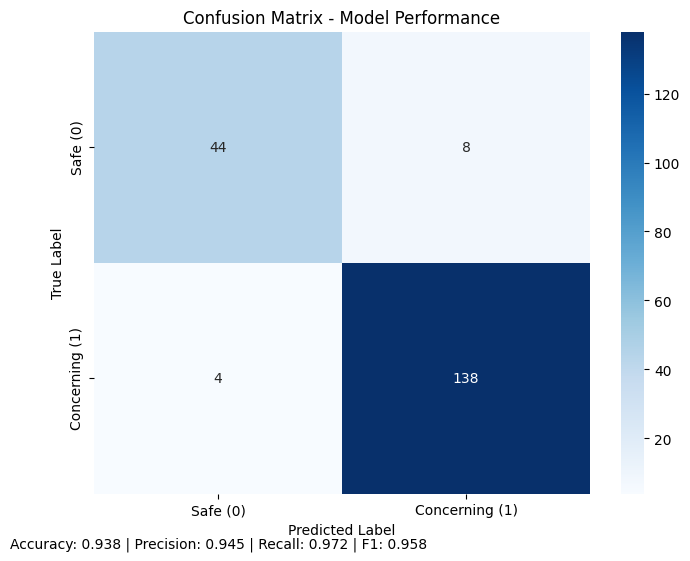

✅ Confusion matrix saved to: /content/drive/Shareddrives/CS152 Group 15/discord_safety_model/user_test_results/confusion_matrix.png

🔍 Analyzing misclassifications...
📊 Misclassification Analysis:
  Total samples: 194
  Correctly classified: 182
  Misclassified: 12

📋 Breakdown of misclassifications:
  • False Positive: 8
  • False Negative: 4
✅ Misclassified messages saved to: /content/drive/Shareddrives/CS152 Group 15/discord_safety_model/user_test_results/misclassified_messages_20250529_051917.csv

🔍 Examples of misclassifications (lowest confidence first):

  Message: 'How do you deal with feelings of loneliness?'
  True: CONCERNING | Predicted: SAFE | Confidence: 0.569
  Type: False Negative

  Message: 'Santa, have you ever had to deal with a situation where someone was being particularly selfish?'
  True: SAFE | Predicted: CONCERNING | Confidence: 0.721
  Type: False Positive

  Message: 'How do you cope with feelings of rejection?'
  True: CONCERNING | Predicted: SAFE | Confide

In [ ]:
def test_model_on_csv(csv_path, model_path, save_dir, max_length=128, batch_size=16):
    """
    Test the trained model on a CSV file and generate comprehensive analysis

    Args:
        csv_path: Path to CSV file with 'message' and 'label' columns
        model_path: Path to the trained model
        save_dir: Directory to save results
        max_length: Maximum token length
        batch_size: Batch size for inference
    """
    print("🧪 Starting model testing and analysis...")

    # Load the model
    print("Loading model...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokenizer = DistilBertTokenizer.from_pretrained(model_path)
    model = DistilBertForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()
    print(f"✅ Model loaded on {device}")

    # Load test data
    print(f"Loading test data from: {csv_path}")
    try:
        test_df = pd.read_csv(csv_path)
        print(f"✅ Loaded {len(test_df)} test samples")

        # Verify required columns
        if 'message' not in test_df.columns or 'label' not in test_df.columns:
            raise ValueError("CSV must contain 'message' and 'label' columns")

        test_messages = test_df['message'].astype(str).tolist()
        test_labels = test_df['label'].tolist()

    except Exception as e:
        print(f"❌ Error loading CSV: {e}")
        return

    # Create test dataset and dataloader
    test_dataset = DiscordDataset(test_messages, test_labels, tokenizer, max_length)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Run inference
    print("🔍 Running inference on test data...")
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Get predictions and probabilities
            probs = torch.softmax(outputs.logits, dim=1)
            predictions = torch.argmax(probs, dim=1)

            all_predictions.extend(predictions.cpu().tolist())
            all_probabilities.extend(probs.cpu().tolist())
            all_true_labels.extend(labels.cpu().tolist())

    # Calculate metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true_labels, all_predictions, average='binary'
    )

    print(f"\n📊 TEST RESULTS:")
    print(f"  ✓ Accuracy: {accuracy:.4f}")
    print(f"  ✓ Precision: {precision:.4f}")
    print(f"  ✓ Recall: {recall:.4f}")
    print(f"  ✓ F1 Score: {f1:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)

    # Create and save confusion matrix plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Safe (0)', 'Concerning (1)'],
                yticklabels=['Safe (0)', 'Concerning (1)'])
    plt.title('Confusion Matrix - Model Performance')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Add performance metrics to plot
    plt.figtext(0.02, 0.02, f'Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}',
                fontsize=10, ha='left')

    cm_path = os.path.join(save_dir, 'confusion_matrix.png')
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Confusion matrix saved to: {cm_path}")

    # Analyze misclassifications
    print("\n🔍 Analyzing misclassifications...")

    # Create detailed results dataframe
    results_df = pd.DataFrame({
        'message': test_messages,
        'true_label': all_true_labels,
        'predicted_label': all_predictions,
        'safe_probability': [probs[0] for probs in all_probabilities],
        'concerning_probability': [probs[1] for probs in all_probabilities],
        'confidence': [max(probs) for probs in all_probabilities]
    })

    # Add classification status
    results_df['correct'] = results_df['true_label'] == results_df['predicted_label']
    results_df['classification_type'] = results_df.apply(lambda row:
        'True Negative' if row['true_label'] == 0 and row['predicted_label'] == 0 else
        'True Positive' if row['true_label'] == 1 and row['predicted_label'] == 1 else
        'False Positive' if row['true_label'] == 0 and row['predicted_label'] == 1 else
        'False Negative', axis=1)

    # Extract misclassified messages
    misclassified_df = results_df[~results_df['correct']].copy()
    misclassified_df = misclassified_df.sort_values('confidence', ascending=True)  # Sort by confidence (least confident first)

    print(f"📊 Misclassification Analysis:")
    print(f"  Total samples: {len(results_df)}")
    print(f"  Correctly classified: {len(results_df[results_df['correct']])}")
    print(f"  Misclassified: {len(misclassified_df)}")

    if len(misclassified_df) > 0:
        print(f"\n📋 Breakdown of misclassifications:")
        misclass_breakdown = misclassified_df['classification_type'].value_counts()
        for error_type, count in misclass_breakdown.items():
            print(f"  • {error_type}: {count}")

        # Save misclassified messages
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        misclass_path = os.path.join(save_dir, f'misclassified_messages_{timestamp}.csv')
        misclassified_df.to_csv(misclass_path, index=False)
        print(f"✅ Misclassified messages saved to: {misclass_path}")

        # Show examples of misclassifications
        print(f"\n🔍 Examples of misclassifications (lowest confidence first):")
        for idx, row in misclassified_df.head(10).iterrows():
            true_label_text = "CONCERNING" if row['true_label'] == 1 else "SAFE"
            pred_label_text = "CONCERNING" if row['predicted_label'] == 1 else "SAFE"
            print(f"\n  Message: '{row['message'][:100]}{'...' if len(row['message']) > 100 else ''}'")
            print(f"  True: {true_label_text} | Predicted: {pred_label_text} | Confidence: {row['confidence']:.3f}")
            print(f"  Type: {row['classification_type']}")

    # Save complete results
    results_path = os.path.join(save_dir, f'test_results_{timestamp}.csv')
    results_df.to_csv(results_path, index=False)
    print(f"✅ Complete results saved to: {results_path}")

    # Generate summary report
    summary = {
        'test_date': datetime.now().isoformat(),
        'total_samples': len(results_df),
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'confusion_matrix': {
            'true_negatives': int(cm[0,0]),
            'false_positives': int(cm[0,1]),
            'false_negatives': int(cm[1,0]),
            'true_positives': int(cm[1,1])
        },
        'misclassifications': int(len(misclassified_df)),
        'model_path': model_path,
        'test_data_path': csv_path
    }

    summary_path = os.path.join(save_dir, f'test_summary_{timestamp}.json')
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"✅ Test summary saved to: {summary_path}")

    return results_df, misclassified_df

# RUN THE TEST
if __name__ == "__main__":
    # Configuration
    drive_base = '/content/drive/Shareddrives/CS152 Group 15'
    project_dir = os.path.join(drive_base, 'discord_safety_model')
    model_path = os.path.join(project_dir, 'best_model')

    test_csv_path = os.path.join(project_dir, 'user_val_data.csv')

    # Create results directory
    results_dir = os.path.join(project_dir, 'user_test_results')
    os.makedirs(results_dir, exist_ok=True)

    # Check if model exists
    if not os.path.exists(model_path):
        print(f"❌ Model not found at: {model_path}")
        print("Please train the model first!")
    elif not os.path.exists(test_csv_path):
        print(f"❌ Test data not found at: {test_csv_path}")
        print("Please provide a CSV file with 'message' and 'label' columns")
    else:
        # Run the test
        results_df, misclassified_df = test_model_on_csv(
            csv_path=test_csv_path,
            model_path=model_path,
            save_dir=results_dir,
            max_length=128,
            batch_size=16
        )

        print(f"\n🎉 Testing complete! Results saved in: {results_dir}")
        print(f"\n📁 Generated files:")
        print(f"  • confusion_matrix.png - Visual confusion matrix")
        print(f"  • misclassified_messages_*.csv - Detailed misclassifications")
        print(f"  • test_results_*.csv - Complete test results")
        print(f"  • test_summary_*.json - Summary statistics")


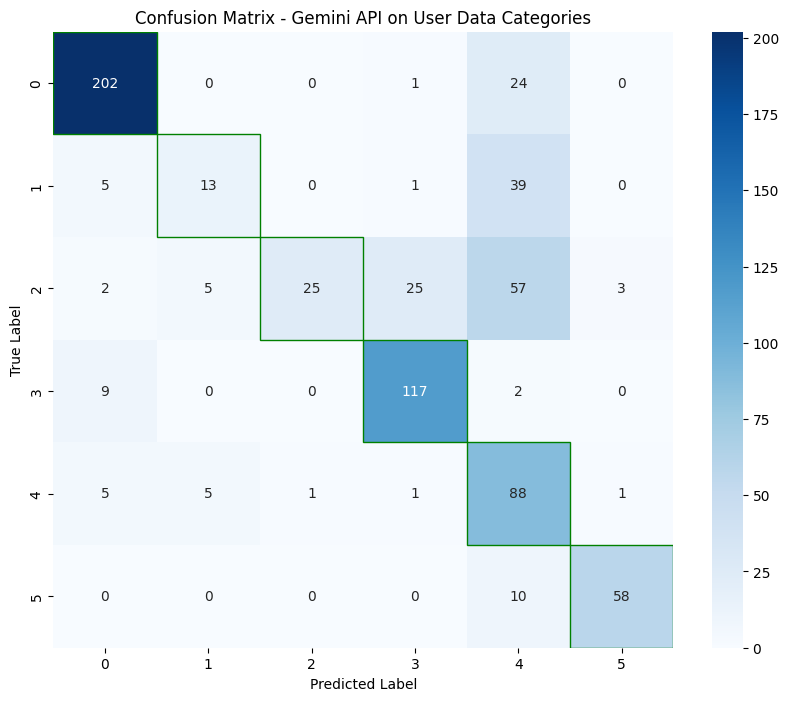

In [ ]:
# Configuration
drive_base = '/content/drive/Shareddrives/CS152 Group 15'
project_dir = os.path.join(drive_base, 'discord_safety_model')

cm = np.array([
  [202,0,0,1,24,0],
  [5,13,0,1,39,0],
  [2,5,25,25,57,3],
  [9,0,0,117,2,0],
  [5,5,1,1,88,1],
  [0,0,0,0,10,58]
])

plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1, 2, 3, 4, 5],
            yticklabels=[0, 1, 2, 3, 4, 5])
plt.title('Confusion Matrix - Gemini API on User Data Categories')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

for i in range(6):
    # outline each diagonal cell
    rect = Rectangle((i, i), 1, 1, linewidth=1, edgecolor='green', facecolor='none')
    ax.add_patch(rect)

cm_path = os.path.join(project_dir, 'categories_confusion_matrix.png')
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.show()

The following cells are for environment debugging purposes:

In [ ]:
from google.colab import drive
import os

os.path.exists('/content/drive')
os.listdir('/content/drive/Shareddrives/')
os.listdir('/content/drive/Shareddrives/CS152 Group 15/')
os.listdir('/content/drive/Shareddrives/CS152 Group 15/discord_safety_model')

['dummy_test_results']

In [ ]:
# Zip the model directory
!zip -r discord_safety_model.zip discord_safety_model/

# Download to your computer
from google.colab import files
files.download('discord_safety_model.zip')